In [1]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.models import load_model
from keras.models import Sequential
from keras.utils import to_categorical
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import csv
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
# set global variables and hyper-parameters
DATA_LOCATION = '../data/'
TRAIN_IMAGES_LOCATION = '../data/train_images/'
IMAGE_SIZE = 64
N_CLASSES = 121
BATCH_SIZE = 128
N_EPOCHS = 20

# load train images filenames with class labels
filenames = [i for i in os.listdir('../data/train_images') if i.endswith('.jpg')]
with open(DATA_LOCATION + 'train_onelabel.csv', mode='r') as infile:
    reader = csv.reader(infile)
    file_to_class = {rows[0]:rows[1] for rows in reader}
    
filenames = filenames[:1000]

X = np.empty([len(filenames)*4,IMAGE_SIZE,IMAGE_SIZE,1])
Y = np.empty([len(filenames)*4,N_CLASSES])
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y.shape))

Shapes:
X:(4000, 64, 64, 1)
Y:(4000, 121)


In [3]:
def get_padding(i):
    """
    Helper function for getting right padding sizes
    input:
        - i: positive integer gotten from substracting height and width of an image
    output:
        - Tuple representing the correct padding
    """
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))

def pad_image(img):
    """
    Add padding to image to make it square
    input:
        - img: numpy array (2D) representing image
    output:
        - padded array of shape (N,N)
    """
    H, W = img.shape
    if H == W:
        return img
    elif H > W:
        return np.pad(img, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(img, (get_padding(W-H), (0,0)), 'constant')

def resize_image(img):
    """
    Resize image to new square shape
    input:
        - img: numpy array (2D) representing image
        - size: final shape of image in pixels (integer)
    """
    return resize(img, (IMAGE_SIZE,IMAGE_SIZE), mode='reflect')

For image in filenames:
- load file
- from [0,255] to [0.0 to 1.0]
- square and resize image
- rotate [0,90,180,270]
- add 4 images to X
- look up label in .csv
- add 4 labels to Y

Rotation can be done through ImageDataGenerator. However, this increases runtime exponentially. 

`numpy.rot90(numpy.ndarray, nr_of_90_degrees_rotations)` might be a better option.

In [4]:
total = len(filenames)
for i in range(len(filenames)):
    # read and transform image to usable format
    img = mpimg.imread(TRAIN_IMAGES_LOCATION + filenames[i])
    img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    img = resize_image(pad_image(img))
    # create a grayscale channel 
    img = img.reshape(64,64,1)
    
    for j in range(4):
        X[i+j*total] = np.rot90(img,j)
        Y[i+j*total][int(file_to_class[filenames[i]])] = 1.0

In [8]:
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y.shape))

Shapes:
X:(4000, 64, 64, 1)
Y:(4000, 121)


In [9]:
# select a random train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X[0].shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [11]:
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_test,y_test),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1)

Train on 3600 samples, validate on 400 samples
Epoch 1/20
3600/3600 [==============================] - 106s - loss: 4.1835 - acc: 0.1303 - val_loss: 3.5257 - val_acc: 0.2025
Epoch 2/20
3600/3600 [==============================] - 92s - loss: 3.5071 - acc: 0.2053 - val_loss: 3.2324 - val_acc: 0.2400
Epoch 3/20
3600/3600 [==============================] - 90s - loss: 3.1682 - acc: 0.2503 - val_loss: 3.3292 - val_acc: 0.2200
Epoch 4/20
3600/3600 [==============================] - 92s - loss: 2.8738 - acc: 0.3075 - val_loss: 2.8327 - val_acc: 0.3350
Epoch 5/20
3600/3600 [==============================] - 92s - loss: 2.5847 - acc: 0.3539 - val_loss: 2.6907 - val_acc: 0.3500
Epoch 6/20
3600/3600 [==============================] - 92s - loss: 2.3445 - acc: 0.3769 - val_loss: 2.6254 - val_acc: 0.3475
Epoch 7/20
3600/3600 [==============================] - 89s - loss: 2.1391 - acc: 0.4236 - val_loss: 2.5985 - val_acc: 0.3450
Epoch 8/20
3600/3600 [==============================] - 94s - loss: 2.

In [12]:
model.save('../data/output/models/model5.h5')

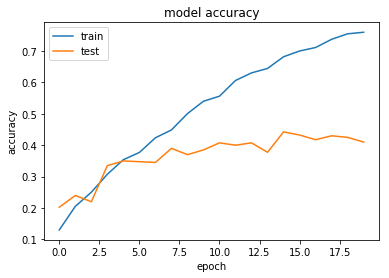

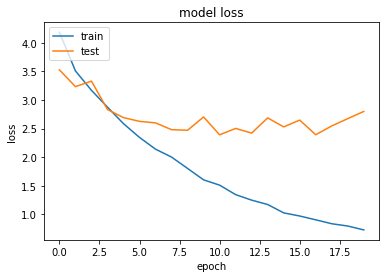

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()